## Add Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.preprocessing import image

import splitfolders
import os
import shutil
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout 
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping

## Read In Data

In [2]:
# pokedex
df1 = pd.read_csv("data/pokedex.csv", index_col=0)
df1["image_address"] = df1["image"]
df1 = df1.drop(columns = "image")

# pokedex4
df2 = pd.read_csv("data/pokedex4.csv", index_col=0)

# concat dataframes
df = pd.concat([df1, df2])
df = df.drop(columns = "type2")
df

,dex_no,name,type1,image_name,image_address
0,1.0,Bulbasaur,Grass,bulbasaur.jpg,https://img.pokemondb.net/sprites/home/normal/...
1,2.0,Ivysaur,Grass,ivysaur.jpg,https://img.pokemondb.net/sprites/home/normal/...
2,3.0,Venusaur,Grass,venusaur.jpg,https://img.pokemondb.net/sprites/home/normal/...
3,4.0,Charmander,Fire,charmander.jpg,https://img.pokemondb.net/sprites/home/normal/...
4,5.0,Charmeleon,Fire,charmeleon.jpg,https://img.pokemondb.net/sprites/home/normal/...
...,...,...,...,...,...
1150,NaN,Iron_Valiant,Fairy,2Iron_Valiant.png,archives.bulbagarden.net/media/upload/thumb/2/...
1151,NaN,Koraidon,Fighting,2Koraidon.png,archives.bulbagarden.net/media/upload/thumb/a/...
1152,NaN,Miraidon,Electric,2Miraidon.png,archives.bulbagarden.net/media/upload/thumb/1/...
1153,NaN,Walking_Wake,Water,2Walking_Wake.png,archives.bulbagarden.net/media/upload/thumb/b/...


In [4]:
# make new dataframe out of all the images listed in the images folder
df_imagesonly = pd.DataFrame(os.listdir("data/images"))
df_imagesonly.columns = ["image_name"]
df_imagesonly["name"] = df_imagesonly["image_name"]
df_imagesonly["name"] = df_imagesonly["name"].str.replace(".png", "").str.replace(".jpg", "").str.replace(".svg", "")
df_imagesonly["name"] = df_imagesonly["name"].str.replace("\d+", "")
df_imagesonly["name"] = df_imagesonly["name"].str.capitalize()
df_imagesonly

/var/folders/x7/5j65n6x57hq9g5yst5z9k1m00000gn/T/ipykernel_1943/28257246.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df_imagesonly["name"] = df_imagesonly["name"].str.replace(".png", "").str.replace(".jpg", "").str.replace(".svg", "")
/var/folders/x7/5j65n6x57hq9g5yst5z9k1m00000gn/T/ipykernel_1943/28257246.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df_imagesonly["name"] = df_imagesonly["name"].str.replace("\d+", "")


,image_name,name
0,Ninetales24.jpg,Ninetales
1,Staryu58.jpg,Staryu
2,Krabby39.jpg,Krabby
3,Sandshrew24.jpg,Sandshrew
4,2Wooper.png,Wooper
...,...,...
9341,Tentacruel19.svg,Tentacruel
9342,Pidgeot7.jpg,Pidgeot
9343,2Excadrill.png,Excadrill
9344,2Tynamo.png,Tynamo


In [5]:
# create new dataframe for just names and types
names_and_types = df[["name", "type1"]]

# combine with df_imagesonly
images_types = df_imagesonly.merge(names_and_types, how = "left")
images_types = images_types.dropna()
images_types

,image_name,name,type1
0,Ninetales24.jpg,Ninetales,Fire
1,Ninetales24.jpg,Ninetales,Fire
2,Staryu58.jpg,Staryu,Water
3,Staryu58.jpg,Staryu,Water
4,Krabby39.jpg,Krabby,Water
...,...,...,...
18342,2Excadrill.png,Excadrill,Ground
18343,2Tynamo.png,Tynamo,Electric
18344,2Tynamo.png,Tynamo,Electric
18345,Venusaur9.jpg,Venusaur,Grass


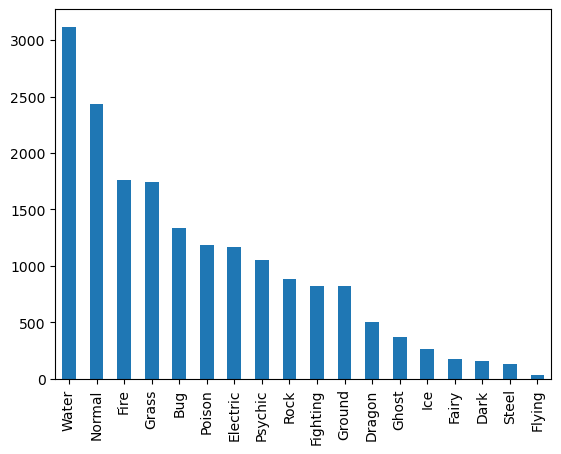

In [6]:
images_types.type1.value_counts().plot(kind='bar');

In [7]:
# remove rows that do not contain main types
main_types = ["Water", "Normal", "Grass", "Pyschic", "Bug", "Fire", "Poison", "Ground", "Fighting", "Rock"]
images_types = images_types[images_types['type1'].isin(main_types)]
images_types

,image_name,name,type1
0,Ninetales24.jpg,Ninetales,Fire
1,Ninetales24.jpg,Ninetales,Fire
2,Staryu58.jpg,Staryu,Water
3,Staryu58.jpg,Staryu,Water
4,Krabby39.jpg,Krabby,Water
...,...,...,...
18340,Pidgeot7.jpg,Pidgeot,Normal
18341,2Excadrill.png,Excadrill,Ground
18342,2Excadrill.png,Excadrill,Ground
18345,Venusaur9.jpg,Venusaur,Grass


## Split Folders for Train-Test and By Class

In [40]:
# create train-test-validation folders
splitfolders.ratio('data', output="train_test_folders", seed=1337, ratio=(.8, 0.0, 0.2)) 

# add images to folders
train_list = []
for image in os.listdir("train_test_folders/train/images"):
    train_list.append(image)
    
test_list = []
for image in os.listdir("train_test_folders/test/images"):
    test_list.append(image)

    
# note in dataframe which folder image is in
train_df = images_types.loc[images_types.apply(lambda row: row["image_name"] in train_list, axis=1)]
test_df = images_types.loc[images_types.apply(lambda row: row["image_name"] in test_list, axis=1)]

train_df["split"] = "train"
test_df["split"] = "test"

pdList = [train_df, test_df]
df_tts = pd.concat(pdList)
df_tts

/var/folders/x7/5j65n6x57hq9g5yst5z9k1m00000gn/T/ipykernel_1943/919130472.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["split"] = "train"
/var/folders/x7/5j65n6x57hq9g5yst5z9k1m00000gn/T/ipykernel_1943/919130472.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["split"] = "test"


,image_name,name,type1,split
2,Staryu58.jpg,Staryu,Water,train
3,Staryu58.jpg,Staryu,Water,train
4,Krabby39.jpg,Krabby,Water,train
5,Krabby39.jpg,Krabby,Water,train
6,Sandshrew24.jpg,Sandshrew,Ground,train
...,...,...,...,...
18306,2Scizor.png,Scizor,Bug,test
18319,Charmander250.png,Charmander,Fire,test
18320,Charmander250.png,Charmander,Fire,test
18331,2Inteleon.png,Inteleon,Water,test


Krabby39.jpg
Sandshrew24.jpg
2Wooper.png
Beedrill3.jpg
Hitmonlee56.jpg
Dragonair37.jpg
Oddish33.jpg
Raticate16.jpg
Persian29.jpg
2Charmeleon.png
Hitmonlee42.jpg
Dragonair23.jpg
Sandshrew30.jpg
Magmar11.jpg
2Silvally.png
Lickitung14.jpg
2Tinkatuff.png
Venusaur4.jpg
Ninetales30.jpg
staraptor.jpg
Beedrill16.jpg
2Mesprit.png
Magnemite1.jpg
Magmar39.jpg
taillow.jpg
2Marowak.png
Marowak35.jpg
2Litten.png
Seel16.jpg
Bulbasaur286.jpg
Ninetales18.jpg
Growlithe9.jpg
charizard.jpg
Vileplume55.jpg
Primeape15.jpeg
Meowth62.jpg
Kangaskhan15.jpg
Ditto41.jpg
Mewtwo97.jpg
Articuno50.jpg
infernape.jpg
Flareon58.jpg
Articuno44.jpg
morgrem.jpg
comfey.jpg
Pikachu277.jpg
Vileplume41.jpg
Persian15.jpg
Krabby11.jpg
Squirtle228.jpg
Vaporeon66.jpg
Pinsir40.jpg
Poliwrath42.jpg
Electabuzz42.jpg
Bulbasaur279.jpg
Golduck12.jpg
Pikachu16.jpg
bulbasaur.jpg
Tentacool31.jpg
2Groudon.png
2Glimmora.png
Mewtwo68.jpg
Psyduck20.jpg
2Ribombee.png
2Delphox.png
Tentacool25.jpg
Poliwrath56.jpg
Drowzee1.jpg
Parasect40.jpg
Caterp

In [42]:
# add class folders and organize images
train_dir = 'train_test_folders/train/images'
test_dir = 'train_test_folders/test/images'

for index, row in df_tts.iterrows():
    class_label = row['type1']  
    filename = row['image_name']  
    if class_label not in os.listdir(train_dir):
        os.mkdir(os.path.join(train_dir, class_label))
    if class_label not in os.listdir(test_dir):
        os.mkdir(os.path.join(test_dir, class_label))
    if row['split'] == 'train':
        shutil.move(os.path.join(train_dir, filename), os.path.join(train_dir, class_label))
    elif row['split'] == 'test':
        shutil.move(os.path.join(test_dir, filename), os.path.join(test_dir, class_label))

Error: Destination path 'train_test_folders/train/images/Water/Staryu58.jpg' already exists

In [31]:
# create generators
train_path = "train_test_folders/train/images"
test_path = "train_test_folders/test/images"

data_gen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)

train_generator = data_gen.flow_from_directory(train_path, target_size = (224, 224), color_mode ='rgb', 
                                                    batch_size = 32, class_mode='categorical')

test_generator = data_gen.flow_from_directory(test_path, target_size = (224, 224), color_mode ='rgb',
                                              batch_size = 32, class_mode='categorical')

Found 1 images belonging to 1 classes.
Found 0 images belonging to 1 classes.


## Base Model

In [18]:
reg = l2(3e-3)
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer = reg))
model.add(Dense(32, activation='relu', kernel_regularizer = reg))
model.add(Dense(16, activation='relu', kernel_regularizer = reg))
model.add(Dense(10, activation='softmax', kernel_regularizer = reg))

Metal device set to: Apple M1 Pro


2023-03-27 19:50:13.134336: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-27 19:50:13.134471: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [34]:
cce = tf.keras.losses.CategoricalCrossentropy()
opt = keras.optimizers.Adam(learning_rate=0.01)
num_of_train_samples = 1311
num_of_test_samples = 325
batch_size = 32
model.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])

In [20]:
base_model = model.fit(
        train_generator, verbose = 1, 
        validation_data = test_generator, 
        epochs=100)

Epoch 1/100


2023-03-27 19:50:13.315281: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-27 19:50:13.497342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


35/41 [========================>.....] - ETA: 2s - loss: 77.2225 - accuracy: 0.1600

/opt/homebrew/Caskroom/miniforge/base/envs/middle-earth/lib/python3.8/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


41/41 [==============================] - ETA: 0s - loss: 71.8528 - accuracy: 0.1670

2023-03-27 19:50:30.219227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 20s 489ms/step - loss: 71.8528 - accuracy: 0.1670 - val_loss: 36.8438 - val_accuracy: 0.1538
Epoch 2/100
41/41 [==============================] - 20s 486ms/step - loss: 22.2105 - accuracy: 0.1846 - val_loss: 12.1556 - val_accuracy: 0.1538
Epoch 3/100
41/41 [==============================] - 20s 484ms/step - loss: 8.1333 - accuracy: 0.1846 - val_loss: 5.3945 - val_accuracy: 0.1538
Epoch 4/100
41/41 [==============================] - 20s 483ms/step - loss: 4.1852 - accuracy: 0.1846 - val_loss: 3.3805 - val_accuracy: 0.1538
Epoch 5/100
41/41 [==============================] - 20s 484ms/step - loss: 2.9688 - accuracy: 0.1846 - val_loss: 2.7367 - val_accuracy: 0.1538
Epoch 6/100
41/41 [==============================] - 20s 485ms/step - loss: 2.5724 - accuracy: 0.1846 - val_loss: 2.5194 - val_accuracy: 0.1538
Epoch 7/100
41/41 [==============================] - 20s 483ms/step - loss: 2.4439 - accuracy: 0.1846 - val_loss: 2.4614 - val_accuracy: 0.1538


Epoch 58/100
41/41 [==============================] - 20s 485ms/step - loss: 2.3005 - accuracy: 0.1846 - val_loss: 2.3302 - val_accuracy: 0.1538
Epoch 59/100
41/41 [==============================] - 20s 486ms/step - loss: 2.2838 - accuracy: 0.1846 - val_loss: 2.3245 - val_accuracy: 0.1538
Epoch 60/100
41/41 [==============================] - 20s 487ms/step - loss: 2.2813 - accuracy: 0.1846 - val_loss: 2.3244 - val_accuracy: 0.1538
Epoch 61/100
41/41 [==============================] - 20s 487ms/step - loss: 2.2820 - accuracy: 0.1846 - val_loss: 2.3240 - val_accuracy: 0.1538
Epoch 62/100
41/41 [==============================] - 20s 484ms/step - loss: 2.2806 - accuracy: 0.1846 - val_loss: 2.3225 - val_accuracy: 0.1538
Epoch 63/100
41/41 [==============================] - 20s 486ms/step - loss: 2.2792 - accuracy: 0.1846 - val_loss: 2.3232 - val_accuracy: 0.1538
Epoch 64/100
41/41 [==============================] - 20s 489ms/step - loss: 2.2790 - accuracy: 0.1846 - val_loss: 2.3192 - val_ac

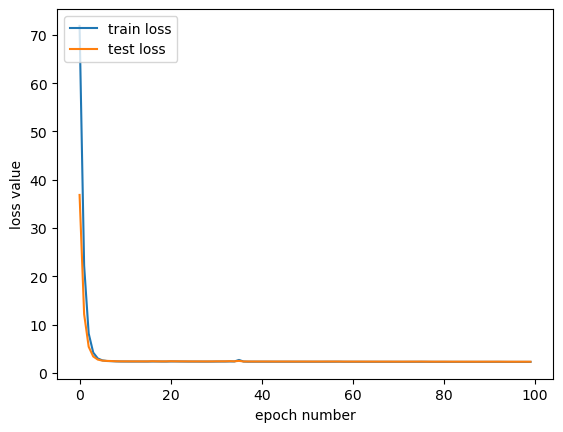

In [21]:
plt.plot(base_model.history["loss"], label = "train loss");
plt.plot(base_model.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

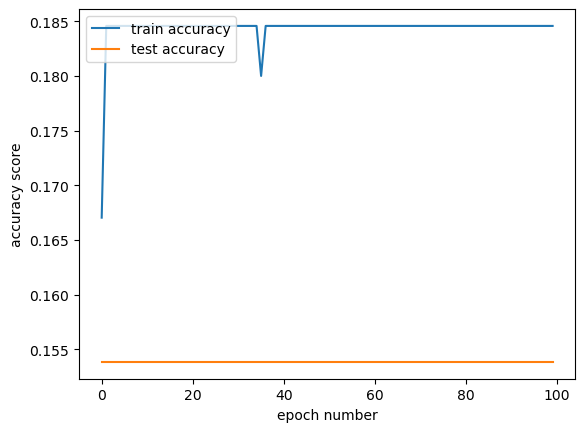

In [22]:
plt.plot(base_model.history["accuracy"], label = "train accuracy");
plt.plot(base_model.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

In [38]:
X_train, y_train = next(train_generator)
X_test, y_test = next(test_generator)

In [43]:
X_test

array([[[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        ...,

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 

In [36]:
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(test_generator, 
                                 num_of_test_samples // batch_size+1)

y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

/var/folders/x7/5j65n6x57hq9g5yst5z9k1m00000gn/T/ipykernel_28893/3687381743.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator,


Confusion Matrix
[[ 0  0  0  0  0  0  0  0  0 32]
 [ 0  0  0  0  0  0  0  0  0 17]
 [ 0  0  0  0  0  0  0  0  0 32]
 [ 0  0  0  0  0  0  0  0  0 23]
 [ 0  0  0  0  0  0  0  0  0 46]
 [ 0  0  0  0  0  0  0  0  0 21]
 [ 0  0  0  0  0  0  0  0  0 50]
 [ 0  0  0  0  0  0  0  0  0 27]
 [ 0  0  0  0  0  0  0  0  0 27]
 [ 0  0  0  0  0  0  0  0  0 50]]


In [47]:
y_proba = model.predict(X_test)

1/1 [==============================] - 0s 16ms/step


In [49]:
cm_digits = confusion_matrix(y_test, y_proba)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_digits)

disp.plot(cmap=plt.cm.Blues)
plt.show()

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

## Model 2

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer = reg))
model.add(Dense(32, activation='relu', kernel_regularizer = reg))
model.add(Dense(16, activation='relu', kernel_regularizer = reg))
model.add(Dense(10, activation='softmax', kernel_regularizer = reg))
model.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])
model_2 = model.fit(
        train_generator, steps_per_epoch = 2,
        verbose = 1, validation_data = test_generator, 
        epochs = 100)

In [ ]:
plt.plot(model_2.history["loss"], label = "train loss");
plt.plot(model_2.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

In [ ]:
plt.plot(model_2.history["accuracy"], label = "train accuracy");
plt.plot(model_2.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

## Model 3

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer = reg))
model.add(Dense(64, activation='relu', kernel_regularizer = reg))

model.add(Dropout(0.2))

model.add(Dense(32, activation='relu', kernel_regularizer = reg))
model.add(Dense(32, activation='relu', kernel_regularizer = reg))

model.add(Dropout(0.1))

model.add(Dense(32, activation='relu', kernel_regularizer = reg))
model.add(Dense(16, activation='relu', kernel_regularizer = reg))
model.add(Dense(16, activation='relu', kernel_regularizer = reg))
model.add(Dense(10, activation='softmax', kernel_regularizer = reg))
model.compile(optimizer='adam', loss=bce,  metrics=['accuracy'])
model_3 = model.fit(
        train_generator, steps_per_epoch = 2,
        verbose=1, validation_data = test_generator, 
        epochs=100)

In [ ]:
plt.plot(model_3.history["loss"], label = "train loss");
plt.plot(model_3.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

In [ ]:
plt.plot(model_3.history["accuracy"], label = "train accuracy");
plt.plot(model_3.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

## Model 4

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer = reg))
model.add(Dense(64, activation='relu', kernel_regularizer = reg))
model.add(Dense(64, activation='relu', kernel_regularizer = reg))
model.add(Dense(64, activation='relu', kernel_regularizer = reg))
model.add(Dense(64, activation='relu', kernel_regularizer = reg))
model.add(Dense(64, activation='relu', kernel_regularizer = reg))
model.add(Dense(32, activation='relu', kernel_regularizer = reg))
model.add(Dense(32, activation='relu', kernel_regularizer = reg))
model.add(Dense(32, activation='relu', kernel_regularizer = reg))
model.add(Dense(32, activation='relu', kernel_regularizer = reg))
model.add(Dense(32, activation='relu', kernel_regularizer = reg))
model.add(Dense(16, activation='relu', kernel_regularizer = reg))
model.add(Dense(16, activation='relu', kernel_regularizer = reg))
model.add(Dense(16, activation='relu', kernel_regularizer = reg))
model.add(Dense(16, activation='relu', kernel_regularizer = reg))
model.add(Dense(16, activation='relu', kernel_regularizer = reg))
model.add(Dense(10, activation='softmax', kernel_regularizer = reg))
model.compile(optimizer='adam', loss=bce,  metrics=['accuracy'])
model_4 = model.fit(
        train_generator, steps_per_epoch = 2, validation_data = test_generator, 
        epochs=100)

In [ ]:
plt.plot(model_4.history["loss"], label = "train loss");
plt.plot(model_4.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

In [ ]:
plt.plot(model_4.history["accuracy"], label = "train accuracy");
plt.plot(model_4.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

## Model 5